#About the data
This data is from a social media platform - Twitter. The data contains text and is labeled as bullying or not.

* Text: text taken from twitter
* oh_label: bullying or not (1: bullying, 0: not bullying)

In [106]:
import tensorflow as tf

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [108]:
df = pd.read_csv("https://raw.githubusercontent.com/dphi-official/Datasets/master/cyberbullying_data/Training_set_label.csv" )
test_df = pd.read_csv('https://raw.githubusercontent.com/dphi-official/Datasets/master/cyberbullying_data/Testing_set_label.csv')

In [109]:
df.head()

,id,Text,oh_label
0,5.75E+17,@urgedharry @nyazpolitics @greenlinerzjm Then ...,0
1,5.62E+17,RT @RudawEnglish: Dozens of vehicles belonging...,0
2,5.75E+17,@biebervalue @greenlinerzjm Here is the Quran ...,1
3,5.55E+17,@Ceff00 @JosephIsVegan @SumbelinaZ @IronmanL1 ...,1
4,5.76E+17,I would literally kill someone for Jac and Sha...,0


In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15275 entries, 0 to 15274
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        15274 non-null  object
 1   Text      15274 non-null  object
 2   oh_label  15275 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 358.1+ KB


In [111]:
df.oh_label.value_counts()

0    10427
1     4848
Name: oh_label, dtype: int64

1 missing value

In [112]:
df = df.dropna()

### Data Preparation

remove id

In [113]:
df = df.drop(['id'], axis = 1)
test_df = test_df.drop(['id'], axis = 1)

lowering text

In [114]:
df['text_lower'] = df['Text'].str.lower()
test_df['text_lower'] = test_df['Text'].str.lower()

remove url

In [115]:
df['text_no_url'] = df['text_lower'].replace(to_replace=r'http\S+', value='', regex=True)
test_df['text_no_url'] = test_df['text_lower'].replace(to_replace=r'http\S+', value='', regex=True)

remove words start with @ and RT

In [116]:
df['text_no_mention'] = df['text_no_url'].str.replace('@[\w\d]*', '')
test_df['text_no_mention'] = test_df['text_no_url'].str.replace('@[\w\d]*', '')

In [117]:
df['text_no_rt'] = df['text_no_mention'].replace(to_replace=r'\brt\b', value='', regex=True)
test_df['text_no_rt'] = test_df['text_no_mention'].replace(to_replace=r'\brt\b', value='', regex=True)

removing stopwords

In [118]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [119]:
from nltk.corpus import stopwords

In [120]:
stop = stopwords.words('english')

In [121]:
df['text_no_stopwords'] = df['text_no_rt'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))
test_df['text_no_stopwords'] = test_df['text_no_rt'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))

removing punctuation

In [122]:
df['text_no_punc'] = df['text_no_stopwords'].str.replace('[^\w\s]', '')
test_df['text_no_punc'] = test_df['text_no_stopwords'].str.replace('[^\w\s]', '')

In [123]:
df = df.fillna('fillna')
test_df = test_df.fillna('fillna')

Tokenizer

In [137]:
X = df['text_no_punc'].values
y = df['oh_label'].values
X_test = test_df['text_no_punc'].values

In [138]:
max_feat = 5000
max_word_len = 100

In [139]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [140]:
tok = Tokenizer(num_words=max_feat)

In [141]:
tok.fit_on_texts(X)

In [142]:
X = tok.texts_to_sequences(X)
X_test = tok.texts_to_sequences(X_test)

Pad sequences

In [143]:
X = pad_sequences(X, maxlen=max_word_len)
X_test = pad_sequences(X_test, maxlen=max_word_len)

Train / Validaiton Split

In [144]:
from sklearn.model_selection import train_test_split

In [145]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y)

### Model Train

In [164]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Embedding, LSTM, GlobalMaxPool1D

In [165]:
vocab_size = len(tok.word_index) + 1
emb_dim = 50

In [167]:
i = Input(shape=(max_word_len))
x = Embedding(vocab_size, emb_dim)(i)
# x = LSTM(15, return_sequences=True)(x)
# x = GlobalMaxPool1D()(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

In [168]:
model = Model(i, x)
model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 100, 50)           715700    
_________________________________________________________________
flatten_3 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                320064    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 1,035,829
Trainable params: 1,035,829
Non-trainable params: 0
_________________________________________________________________


In [169]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [170]:
r = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5)

Epoch 1/5
358/358 [==============================] - 4s 12ms/step - loss: 0.4813 - accuracy: 0.7787 - val_loss: 0.3919 - val_accuracy: 0.8329
Epoch 2/5
358/358 [==============================] - 4s 12ms/step - loss: 0.2587 - accuracy: 0.8996 - val_loss: 0.3681 - val_accuracy: 0.8591
Epoch 3/5
358/358 [==============================] - 4s 12ms/step - loss: 0.1366 - accuracy: 0.9566 - val_loss: 0.3960 - val_accuracy: 0.8617
Epoch 4/5
358/358 [==============================] - 4s 12ms/step - loss: 0.0776 - accuracy: 0.9787 - val_loss: 0.4710 - val_accuracy: 0.8628
Epoch 5/5
358/358 [==============================] - 4s 12ms/step - loss: 0.0527 - accuracy: 0.9867 - val_loss: 0.5312 - val_accuracy: 0.8610


### Model Evaluation

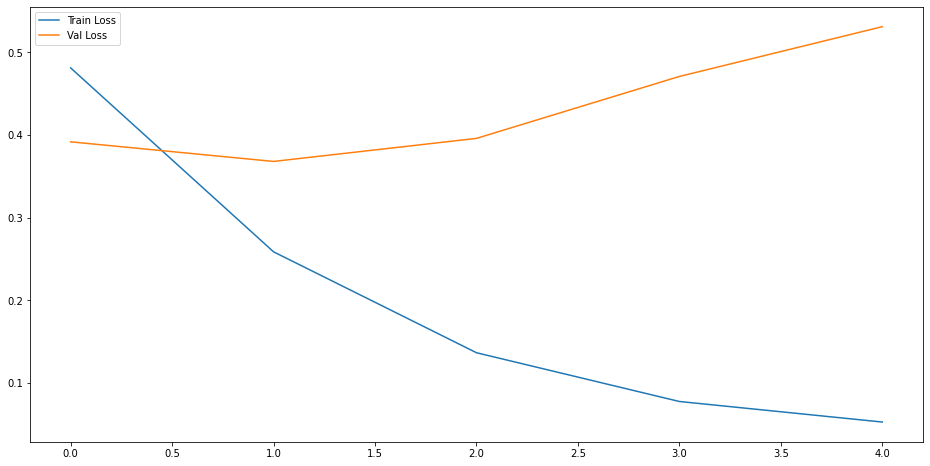

In [172]:
plt.figure(figsize=(16, 8))
plt.plot(r.history['loss'], label='Train Loss')
plt.plot(r.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

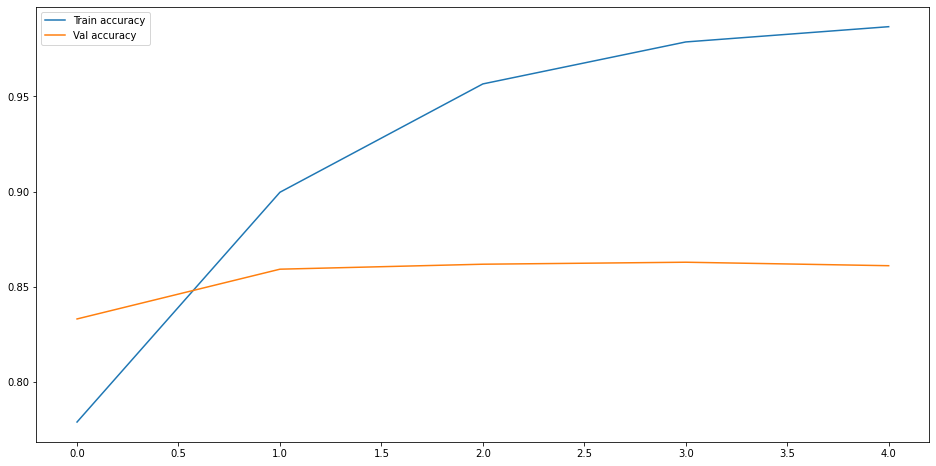

In [173]:
plt.figure(figsize=(16, 8))
plt.plot(r.history['accuracy'], label='Train accuracy')
plt.plot(r.history['val_accuracy'], label='Val accuracy')
plt.legend()
plt.show()

In [174]:
from sklearn.metrics import classification_report, confusion_matrix

In [176]:
y_val_pred = np.round(model.predict(X_val))

In [177]:
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      2607
           1       0.81      0.74      0.77      1212

    accuracy                           0.86      3819
   macro avg       0.85      0.83      0.84      3819
weighted avg       0.86      0.86      0.86      3819



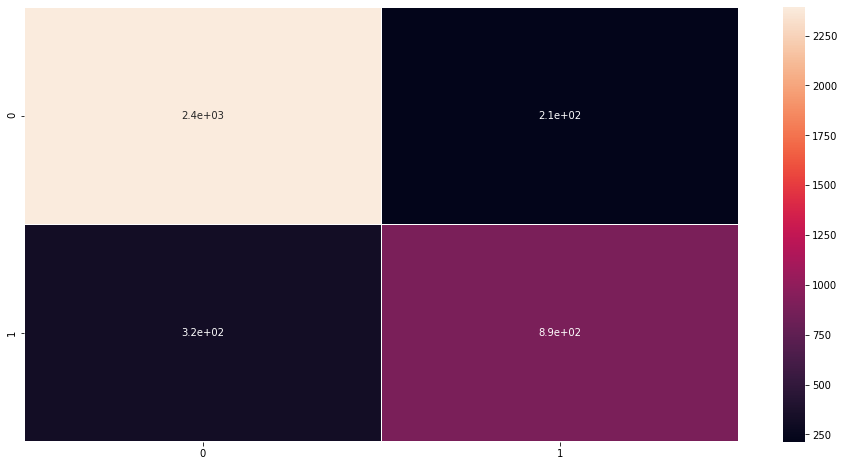

In [179]:
plt.figure(figsize=(16, 8))
sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True, linewidths=0.5)
plt.show()

### Make Predictions

In [180]:
y_pred = np.round(model.predict(X_test))

In [185]:
y_pred.shape

(5056, 1)

In [186]:
r_df = pd.DataFrame({
    'prediction': pd.Series(y_pred.reshape(-1,))
})

In [191]:
r_df['prediction'] = r_df['prediction'].astype(int)

In [192]:
r_df.head()

,prediction
0,0
1,0
2,0
3,0
4,1


In [193]:
from google.colab import files

In [194]:
r_df.to_csv('cyb_pred.csv', index=False)
files.download('cyb_pred.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>